# Filtering expanded dataset

## Core Imports

In [1]:
# Generic Imports
import matplotlib.pyplot as plt
import pandas as pd

# File I/O
from pathlib import Path
import csv, json, openpyxl

# Typing and Subclassing
from typing import Iterable, Optional, Union
from dataclasses import dataclass, field

# Cheminformatics
from rdkit import Chem

# Custom imports
from polymerist.rdutils import rdkdraw
from polymerist.rdutils.smileslib import queries
from polymerist.monomers import specification

DIM    = 300
ASPECT = 3/2
rdkdraw.set_rdkdraw_size(DIM, ASPECT)
rdkdraw.disable_substruct_highlights()

# Static Paths
RAW_DATA_DIR  = Path('monomer_data_raw')
FMT_DATA_DIR  = Path('monomer_data_formatted')
PROC_DATA_DIR = Path('monomer_data_processed')
RXN_FILES_DIR = Path('poly_rxns')
# RXN_FILES_DIR = Path('rxn_smarts')

## Loading desired dataset

In [2]:
# input_data_path = FMT_DATA_DIR / 'nipu_urethanes_FMT.csv'
input_data_path = FMT_DATA_DIR / '20231114_polyid_data_density_DP2-6 - 1,2 monomers.csv'
# input_data_path = FMT_DATA_DIR / '221010_trainingdata_DP-18_expanded_FMT.csv'
df = pd.read_csv(input_data_path)

## Defining queries for illegal chemistries

In [3]:
illegal_chem_queries = {
    'silicon' : Chem.MolFromSmarts('[Si]'),
    'sulfur'  : Chem.MolFromSmarts('[S]'),
    'metal'   : queries.SPECIAL_QUERY_MOLS['metal'],
    # 'halogen' : queries.SPECIAL_QUERY_MOLS['halogen'],
}

## Loading and backmapping premade reaction functional groups and templates

In [4]:
rxn_backmap = { # map NREL dataset mechanism names to pre-made rxn template names
    'amide'     : 'polyamide',
    'carbonate' : 'polycarbonate_phosgene',
    'ester'     : 'polyester',
    'imide'     : 'polyimide',
    'urethane'  : 'polyurethane_isocyanate',
    'NIPU'      : 'polyurethane_nonisocyanate',
    'vinyl'     : 'polyvinyl_head_tail'
}
assert(set(df['mechanism'].unique()).issubset(set(rxn_backmap.keys()))) # verify that we've mapped all reactions

with (RXN_FILES_DIR / 'rxn_backmap.json').open('w') as backmap_file:
    json.dump(rxn_backmap, backmap_file, indent=4)

In [5]:
from polymerist.rdutils.reactions import reactions

with (RXN_FILES_DIR / 'fn_group_smarts.json').open('r') as file:
    fn_group_smarts  = json.load(file)
    
fn_group_queries = { # RDKit Mols generated from SMARTS queries
    group_name : Chem.MolFromSmarts(smarts)
        for group_name, smarts in fn_group_smarts.items()
}

with (RXN_FILES_DIR / 'rxn_groups.json').open('r') as file: # load table of functional group for each reaction
    rxn_groups = json.load(file)

rxns = {
    rxnname : reactions.AnnotatedReaction.from_rxnfile(RXN_FILES_DIR / f'{rxnname}.rxn')
        for rxnname in rxn_groups.keys()
}

In [6]:
banned_monomers = [ # monomers which are, for one reason or another, disallowed
    'CC(C)(C)c1cc(c(Oc2ccc(cc2)N(c3ccc(N)cc3)c4ccc(N)cc4)c(c1)C(C)(C)C)C(C)(C)C'  # the extraordinary number of symmetries of this amine ("4-N-(4-aminophenyl)-4-N-[4-(2,4,6-tritert-butylphenoxy)phenyl]benzene-1,4-diamine")... 
]                                                                                 # ...mean it takes impractically long to isomorphism match during the Topology partition step

banned_monomer_queries = {}
for smiles in banned_monomers:
    exp_spi = specification.expanded_SMILES(smiles, assign_map_nums=False)
    banned_monomer_queries[smiles] = Chem.MolFromSmiles(exp_spi, sanitize=False)

## Utility functions

In [7]:
from enum import Enum, auto

@dataclass
class MonomerInfo:
    '''For encapsulating salient info about an individual monomer'''
    smiles        : str
    fn_group_name : str
    IUPAC_name    : str

class FilterRejectionReason(Enum):
    '''For capturing information about which filtering step a monomer didn't pass'''
    BAD_NUM_MONOMERS      = auto()
    ILLEGAL_ATOMS         = auto()
    NO_RXN_TEMPLATE_MATCH = auto()
    BAD_NUM_FN_GRPS       = auto()
    NO_IUPAC_NAME         = auto()
    BANNED_MONOMER        = auto()

In [8]:
import cirpy
import pubchempy as pcp

def get_IUPAC_name(smiles : str, pc_prop_name : str='IUPACName') -> Optional[str]:
    '''Takes the SMILES string representing a molecule and attempts to fetch its IUPAC name from NIH CACTUS and/or PubChem
    Returns the fetched IUPAC name as a str, or NoneType if both queries fail'''
    # Open with NIH query (fastest method), return name if found...
    iupac_name = cirpy.resolve(smiles, 'iupac_name')
    if iupac_name is not None:
        if isinstance(iupac_name, list):
            return iupac_name.pop()
        return iupac_name 
    
    # ...otherwise, search through PubChem Compound queries for a matching results
    for prop_query in pcp.get_properties(pc_prop_name, smiles, namespace='smiles'):
        if pc_prop_name in prop_query:
            return prop_query[pc_prop_name]
    else:
        return None # TODO : add ChemSpider once I can obtain an API key (https://chemspipy.readthedocs.io/en/latest/guide/intro.html#apikey) 

In [9]:
from polymerist.monomers import specification

def process_monomer_input(smiles : str, mech_name : str) -> Union[FilterRejectionReason, list[MonomerInfo]]:
    '''For screening and expanding SMILES input to the MD polymer building workflow'''
    # 1) Determine number of distrinct monomers in passed SMILES string
    indiv_smiles = smiles.split('.') # opting for direct string-based approach here rather than RDKit Mol fragmenting for speed, and to avoid clunky str -> Mol -> str conversion
    num_monomers = len(indiv_smiles)
    if num_monomers != 2:
        return FilterRejectionReason.BAD_NUM_MONOMERS
    
    # Generate expanded SMILES string and corresponding RDKit Mol for all monomers
    monomers_by_exp_smiles : dict[str, Chem.Mol] = {}
    exp_smiles_by_monomers : dict[Chem.Mol, str] = {} # reverse lookup to figure out the correct smiles given a molecule
    indiv_monomers         : list[Chem.Mol] = []
    
    for smi in indiv_smiles: # wait to expand SMILES until after count filtering for speed
        exp_smi = specification.expanded_SMILES(smi, assign_map_nums=False)
        monomer = Chem.MolFromSmiles(exp_smi, sanitize=False)

        # 2) Catch monomers with illegal atoms or, if none are present, generate expanded SMILES string and corresponding RDKit Mol for all monomers
        if any(queries.matching_labels_from_substruct_dict(monomer, illegal_chem_queries)): # if any illegal atoms are detected in the current monomer, return and exit
            return FilterRejectionReason.ILLEGAL_ATOMS

        # 3) Exclude any monomers which are structurally disallowed
        if any(queries.matching_labels_from_substruct_dict(monomer, banned_monomer_queries)): # if any illegal atoms are detected in the current monomer, return and exit
            return FilterRejectionReason.BANNED_MONOMER
        
        indiv_monomers.append(monomer)
        monomers_by_exp_smiles[exp_smi] = monomer
        exp_smiles_by_monomers[monomer] = exp_smi

    # 4) Determine if monomer functionalizations match the advertised rxn, and if so in what order they should appear
    reactive_groups : list[str] = rxn_groups[rxn_backmap[mech_name]]
    rxn = rxns[rxn_backmap[mech_name]]
    mono_order = rxn.valid_reactant_ordering(indiv_monomers)
    if mono_order is None:
        return FilterRejectionReason.NO_RXN_TEMPLATE_MATCH

    # produce monomers based on a valid ordering if one is found
    mono_info_list : list[MonomerInfo] = []
    for monomer, mono_fn_group in zip(mono_order, reactive_groups, strict=True): # strict just gives one further safeguard that a 1:1 reactive group to monomer mapping has been found
        smiles = exp_smiles_by_monomers[monomer]
        # 5) Determine if all monomers are only have the desired functionalization numbers 
        if queries.num_substruct_queries_distinct(monomer, fn_group_queries[mono_fn_group]) != 2:
            return FilterRejectionReason.BAD_NUM_FN_GRPS
        
        # 6) Query IUPAC names for each monomer - NOTE: not done in the monomer expansion loop as the name query is the slowest step and should preferably alled as few times as possible
        iupac_name = get_IUPAC_name(smiles)
        if iupac_name is None:
            return FilterRejectionReason.NO_IUPAC_NAME
        
        # if a monomer has gotten here, that means it's passed!
        mono_info = MonomerInfo(
            smiles=smiles,
            fn_group_name=mono_fn_group,
            IUPAC_name=iupac_name.lower() # enforce lower-casing for consistency
        )
        mono_info_list.append(mono_info)

    return mono_info_list

# Filter dataset

## Generate filtered Series (either error codes or MonomerInfo) from initial dataset

In [10]:
from rich.progress import track

targ_df = df
# targ_df = df.head(20)
# targ_df = df[df.mechanism == 'vinyl']

proc_output = []
for (i, row) in track(targ_df.iterrows(), total=len(targ_df), description='Processing SMILES dataset...'):
    proc = process_monomer_input(row.smiles_monomer, row.mechanism)
    proc_output.append(proc)

proc_output = pd.Series(proc_output) # convert from list to Series, partition by failure state
was_rejected = proc_output.map(lambda out : isinstance(out, FilterRejectionReason))
rejects = proc_output[ was_rejected]
passes  = proc_output[~was_rejected]

Output()

## Expand successful monomers into labelled DataFrame

In [11]:
def expand_mono_info_list(all_info : list[MonomerInfo]) -> list[str]:
    return {
        f'{attr}_monomer_{j}' : getattr(mono_info, attr)
            for j, mono_info in enumerate(all_info) # NOTE: the index "j" here is NOT the position as determined by monomer sort, but rather the index in the rxn groups ordering
                for attr in ('smiles', 'fn_group_name', 'IUPAC_name')
    }

def get_polymer_name(*monomer_names : list[str]) -> str:
    return f'poly({"-co-".join(monomer_names)})'


passes_as_dict = passes.map(expand_mono_info_list)
passes_df = pd.DataFrame.from_records(passes_as_dict.values, index=passes_as_dict.index)

result_df = pd.concat([passes_df, df.loc[passes_df.index]], axis=1) # combine expanded monomer info with original dataframe
result_df['polymer_name'] = result_df[['IUPAC_name_monomer_0', 'IUPAC_name_monomer_1']].apply(lambda row : get_polymer_name(*row.to_list()), axis=1)

result_df['rxn_name'] = result_df['mechanism'].map(rxn_backmap) # backmap to rxn template name, and assert this name to take precedence as "mechanism"
result_df.rename(columns={'mechanism' : 'mechanism_orig', 'rxn_name' : 'mechanism'}, inplace=True) 

result_df.set_index(['mechanism', 'polymer_name'], inplace=True)
result_df

smiles_monomer_0  \
mechanism              polymer_name                                                                                            
polycarbonate_phosgene poly(4-[1,1,1,3,3,3-hexafluoro-2-(4-hydroxyphen...  [H]-[O]-[C]1=[C](-[H])-[C](-[H])=[C](-[C](-[C]...   
                       poly(4-[2-(4-hydroxy-3,5-dimethylphenyl)propan-...  [H]-[O]-[C]1=[C](-[C](-[H])(-[H])-[H])-[C](-[H...   
polyimide              poly(4-[9-(4-aminophenyl)fluoren-9-yl]aniline-c...  [H]-[C]1=[C](-[H])-[C](-[H])=[C]2-[C](=[C]-1-[...   
                       poly(benzene-1,3-diamine-co-5-[3-tert-butyl-5-(...  [H]-[C]1=[C](-[H])-[C](-[N](-[H])-[H])=[C](-[H...   
                       poly(4-[(4-aminophenyl)methyl]aniline-co-5-[2-(...  [H]-[C]1=[C](-[N](-[H])-[H])-[C](-[H])=[C](-[H...   
...                                                                                                                      ...   
                       poly(4-[4-[2-[4-(4-aminophenoxy)phenyl]propan-2...  [H]-[C]1=[C](-[O]-[C]2=[C](-[H])-[C](-[H])=[C]...   
                       poly(4-[2-(4-amino-3-methylphenyl)-1,1,1,3,3,3-...  [H]-[C]1=[C](-[N](-[H])-[H])-[C](-[C](-[H])(-[...   
                       poly(2,4,6-trimethylbenzene-1,3-diamine-co-5-(1...  [H]-[C]1=[C](-[C](-[H])(-[H])-[H])-[C](-[N](-[...   
polycarbonate_phosgene poly(4-[1-(4-hydroxyphenyl)cycloheptyl]phenol-c...  [H]-[O]-[C]1=[C](-[H])-[C](-[H])=[C](-[C]2(-[C...   
polyester              poly(butane-1,4-diol-co-hexanedioic acid)           [H]-[O]-[C](-[H])(-[H])-[C](-[H])(-[H])-[C](-[...   

                                                                          fn_group_name_monomer_0  \
mechanism              polymer_name                                                                 
polycarbonate_phosgene poly(4-[1,1,1,3,3,3-hexafluoro-2-(4-hydroxyphen...                hydroxyl   
                       poly(4-[2-(4-hydroxy-3,5-dimethylphenyl)propan-...                hydroxyl   
polyimide              poly(4-[9-(4-aminophenyl)fluoren-9-yl]aniline-c...                   amine   
                       poly(benzene-1,3-diamine-co-5-[3-tert-butyl-5-(...                   amine   
                       poly(4-[(4-aminophenyl)methyl]aniline-co-5-[2-(...                   amine   
...                                                                                           ...   
                       poly(4-[4-[2-[4-(4-aminophenoxy)phenyl]propan-2...                   amine   
                       poly(4-[2-(4-amino-3-methylphenyl)-1,1,1,3,3,3-...                   amine   
                       poly(2,4,6-trimethylbenzene-1,3-diamine-co-5-(1...                   amine   
polycarbonate_phosgene poly(4-[1-(4-hydroxyphenyl)cycloheptyl]phenol-c...                hydroxyl   
polyester              poly(butane-1,4-diol-co-hexanedioic acid)                         hydroxyl   

                                                                                                        IUPAC_name_monomer_0  \
mechanism              polymer_name                                                                                            
polycarbonate_phosgene poly(4-[1,1,1,3,3,3-hexafluoro-2-(4-hydroxyphen...  4-[1,1,1,3,3,3-hexafluoro-2-(4-hydroxyphenyl)p...   
                       poly(4-[2-(4-hydroxy-3,5-dimethylphenyl)propan-...  4-[2-(4-hydroxy-3,5-dimethylphenyl)propan-2-yl...   
polyimide              poly(4-[9-(4-aminophenyl)fluoren-9-yl]aniline-c...           4-[9-(4-aminophenyl)fluoren-9-yl]aniline   
                       poly(benzene-1,3-diamine-co-5-[3-tert-butyl-5-(...                                benzene-1,3-diamine   
                       poly(4-[(4-aminophenyl)methyl]aniline-co-5-[2-(...                   4-[(4-aminophenyl)methyl]aniline   
...                                                                                                                      ...   
                       poly(4-[4-[2-[4-(4-aminophenoxy)phenyl]propan-2...  4-[4-[2-[4-(4-aminophenoxy)phe

## Show distribution of failure cases

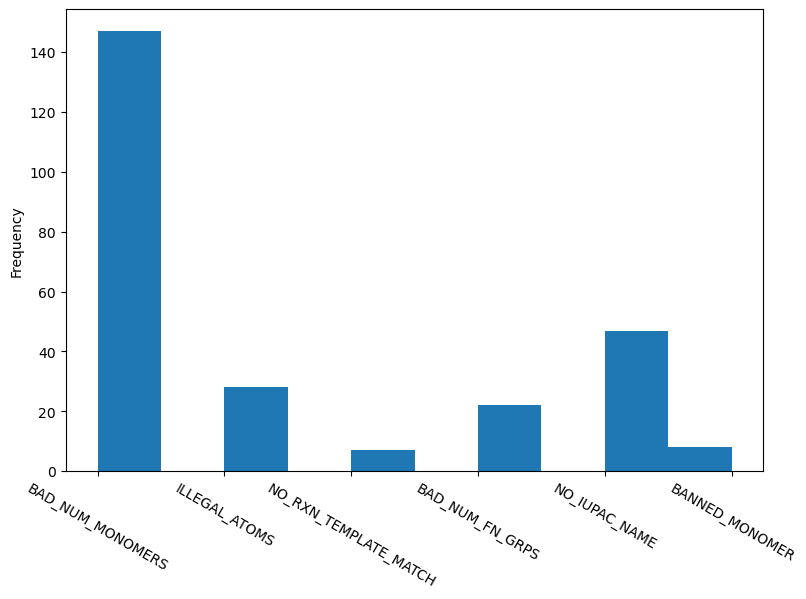

In [12]:
dim = 6
aspect= 3/2

plt.figure(figsize=(dim*aspect, dim))

ax = rejects.map(lambda x : x.value).plot(kind='hist')
ax.set_xticks([i.value for i in FilterRejectionReason])
ax.set_xticklabels([i.name for i in FilterRejectionReason], rotation=-30)

plt.show()

## Save filtered DataFrame for next steps to avoid reprocessing

In [13]:
PROC_DATA_DIR.mkdir(exist_ok=True)
clean_input_stem = input_data_path.stem.removesuffix('_FMT')

# save filtered dataset to filtered directory to store caclulations
out_data_path = PROC_DATA_DIR / f'{clean_input_stem}_FILTERED{input_data_path.suffix}'
result_df.to_csv(out_data_path)

# also keep record of the rejected monomers (and the reasons for rejection)
rejects_data_path = PROC_DATA_DIR / f'{clean_input_stem}_REJECTED{input_data_path.suffix}'
rejects.map(lambda r : r.name).to_csv(rejects_data_path)